Epoch 1/20
36658/36658 [==============================] - 55s 1ms/step - loss: -19400.3926 - accuracy: 0.9809 - val_loss: -104407.5078 - val_accuracy: 0.9912
Epoch 2/20
36658/36658 [==============================] - 47s 1ms/step - loss: -361071.8438 - accuracy: 0.9811 - val_loss: -953379.5000 - val_accuracy: 0.9912
Epoch 3/20
36658/36658 [==============================] - 46s 1ms/step - loss: -1626584.3750 - accuracy: 0.9813 - val_loss: -3270493.7500 - val_accuracy: 0.9912
Epoch 4/20
36658/36658 [==============================] - 47s 1ms/step - loss: -4453994.5000 - accuracy: 0.9815 - val_loss: -7883624.5000 - val_accuracy: 0.9912
Epoch 5/20
36658/36658 [==============================] - 48s 1ms/step - loss: -9426724.0000 - accuracy: 0.9814 - val_loss: -15243097.0000 - val_accuracy: 0.9912
Epoch 6/20
36658/36658 [==============================] - 46s 1ms/step - loss: -17025840.0000 - accuracy: 0.9815 - val_loss: -26404652.0000 - val_accuracy: 0.9912
Epoch 7/20
36658/36658 [============

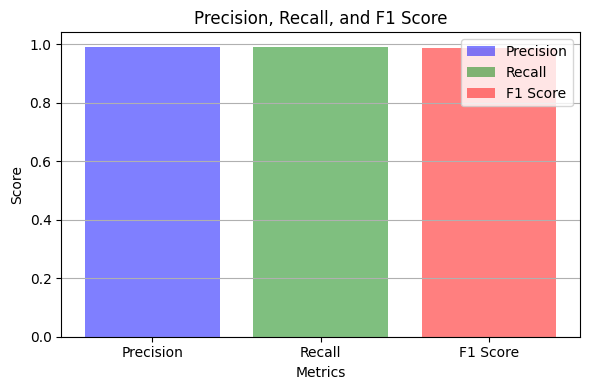

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load sample data (replace with your actual data loading)
data = pd.read_csv("Dataset/Dos_dataset.csv", header=None)
# Assign column names
data.columns = ['Timestamp', 'CAN_ID', 'DLC', 'DATA0', 'DATA1',
                'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']

# Convert Flag column to numerical labels using label encoding
label_encoder = LabelEncoder()
data['Flag'] = label_encoder.fit_transform(data['Flag'])

data["Timestamp"] = pd.to_datetime(data["Timestamp"])

# Convert CAN ID and DLC to integer
data["CAN_ID"] = data["CAN_ID"].apply(lambda x: int(x, 16) if isinstance(x, str) else x)
data["DLC"] = data["DLC"].astype(int)

# Convert DATA fields from hexadecimal strings to integers
def hex_to_int(x):
    if isinstance(x, str):
        try:
            return int(x, 16)
        except ValueError:
            return np.nan
    else:
        return x

for i in range(8):
    data[f"DATA{i}"] = data[f"DATA{i}"].apply(hex_to_int).astype(float)

# Assuming 'Flag' column represents the target variable
X = data.drop('Flag', axis=1)  # Features
y = data['Flag']  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop 'Timestamp' column from input features
X_train = X_train.drop('Timestamp', axis=1)
X_test = X_test.drop('Timestamp', axis=1)

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Define a simple deep learning model
model = Sequential([
    Dense(64, input_shape=(X_train_imputed.shape[1],), activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_imputed, y_train, epochs=20, batch_size=64, validation_split=0.2)

# Evaluate the model on test data
y_pred_probs = model.predict(X_test_imputed)
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate precision, recall, and F1 score

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=1)


# Convert class labels to strings
classes = [str(cls) for cls in label_encoder.classes_]

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

plt.figure(figsize=(6, 4))

# Precision
plt.bar(['Precision'], [precision], color='b', alpha=0.5, label='Precision')

# Recall
plt.bar(['Recall'], [recall], color='g', alpha=0.5, label='Recall')

# F1 Score
plt.bar(['F1 Score'], [f1_score], color='r', alpha=0.5, label='F1 Score')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()